In [1]:
import sys, os
sys.path.insert(0, '/data1/home/rocks/discrete_elasticity_v2/')
sys.path.insert(0, '/data1/home/rocks/discrete_elasticity_v2/python_src/')

import numpy as np
import scipy as sp
import pandas as pd
import cPickle as pickle
import portalocker
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import shutil, shelve
import tarfile
import time



import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

%matplotlib inline

sns.set(color_codes=True)
sns.set_context('poster', font_scale=1.75)
sns.set_palette("hls", 8)
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})


Loading Mechanical Network Deformation Solver Module


In [2]:
t0 = time.time()

# directory = "/data1/home/rocks/data/sat_transition/tune_cont_global_1D/"
# directory = "/data1/home/rocks/data/sat_transition/tune_cont_local_1D/"
directory = "/data1/home/rocks/data/sat_transition/tune_cont_local_2D/"

# directory = "/data1/home/rocks/data/sat_transition/test/"

# directory = "/data1/home/rocks/data/sat_transition/tune_disc_local_2D_slice/"
# directory = "/data1/home/rocks/data/sat_transition/tune_cont_local_2D_surface/"
# directory = "/data1/home/rocks/data/sat_transition/tune_cont_global_2D/"

# os.remove(directory+"tune_lin_db.bin.dat")

files = []

print "Listing files..."

for f in os.listdir(directory):
    if f.endswith(".pkl") and f != "file_list.pkl" and  f != "tune_analysis.pkl":
        files.append(f)
        
        
print "Loading..."

db = shelve.open(directory+"tune_db.bin")    

print "Size of existing database:", len(db)

print "Files to add:", len(files)
  
del_list = []
    
for i, fn in enumerate(files):  
    if i % 1000 == 0:
        print i
      
    if fn not in db:
        try:
            with open(directory + fn, 'rb') as pkl_file:
                data = pickle.load(pkl_file)
                db[fn] = data

            del_list.append(fn)

        except (IOError, EOFError):
            print "Error loading", fn
            continue
    
#     shutil.move(directory + fn, directory + "data/" + fn)    
    
print "Final size of database:", len(db)

file_list = set(db.keys())

db.close()

    
print "Backing up..."

with tarfile.open(directory+"sim_files.tar", 'a') as tar:

    print "Appending to tar..."
    for fn in files:
        tar.add(directory+fn)
        os.remove(directory+fn)


print "Updating file list..."
        
with open(directory+"file_list.pkl", 'wb+') as pkl_file:
    portalocker.lock(pkl_file, portalocker.LOCK_EX)
    
    data = dict({'files' : set(file_list)})
    
    pickle.dump(data, pkl_file)
    
    pkl_file.close()
    
    
print "Complete"

t1 = time.time()
print "Total Time", t1-t0

Listing files...
Loading...
Size of existing database: 600
Files to add: 1735
0
1000
Final size of database: 2335
Backing up...
Appending to tar...
Updating file list...
Complete
Total Time 8.50120019913


In [3]:
t0 = time.time()

# os.remove(directory+"tune_analysis.pkl")

db = shelve.open(directory+"tune_db.bin", flag='r')    

files = set(db.keys())

try:
    with open(directory+"tune_analysis.pkl", 'rb') as pkl_file:
        data = pickle.load(pkl_file)
        df = data['df']
        fn_set = data['fn_set']
        
        print "Size of existing analysis:", len(df.index)
except (IOError, EOFError):
    print "No data. Initializig dataframe..."
    df = pd.DataFrame(columns=['fn', 'NN', 'NTS', 'NE', 'eta',
                               'DZ', 'irec', 'obj_func', 'low_bound',
                               'success_flag', 'result_msg', 'NR'])
    
    fn_set = set()
    
     
files -= fn_set
 
print "Adding", len(files)
    
s_list = []
for i, fn in enumerate(files):
    if i % 1000 == 0:
        print i
        
    fn_set.add(fn)
    
    data = db[fn]
        
    success_flag = data['success_flag']
    result_msg = data['result_msg']

    NE = data['NE']
    DZ = data['DZ']
    NN = data['NN_init']
    irec = data['irec']
    NTS = data['NTS']
    eta = data['eta']
    low_bound = data['low_bound']
    obj_func = data['obj_func']
    NR = len(data['rem_set'])
    
    s_list.append(pd.Series({'fn': fn,
                   'NN':NN, 'NTS':NTS, 'irec':irec, 
                   'NE': NE, 'DZ': DZ, 'eta': eta, 'low_bound': low_bound,
                   'success_flag':success_flag, 'result_msg': result_msg,
                   'obj_func': obj_func, 'NR': NR}))
     
        
df_add = pd.DataFrame(s_list, columns=['fn', 'NN', 'NTS', 'NE', 'eta',
                               'DZ', 'irec', 'obj_func', 'low_bound',
                               'success_flag', 'result_msg', 'NR'])
      
df = pd.concat([df, df_add])
    
db.close()
    
print "Saving..."        

with open(directory+"tune_analysis.pkl", 'wb') as output:
    pickler = pickle.Pickler(output, -1)
    data = {'df': df, 'fn_set': fn_set}
    pickler.dump(data)

print "Final size of analysis:", len(df.index)

t1 = time.time()
print "Total Time", t1-t0

Size of existing analysis: 600
Adding 1735
0
1000
Saving...
Final size of analysis: 2335
Total Time 1.83121395111


In [30]:
shutil.copyfile(directory+"tune_db.bin.dat", directory+"tune_lin_db.bin.dat_backup")
shutil.copyfile(directory+"sim_files.tar", directory+"sim_files.tar_backup")

In [5]:
def wilson_up(p, n):
    z = 1.0
    return 1.0 / (1.0 + z**2/n) * (p + 0.5*z**2 / n + z*np.sqrt(1.0/n * p * (1.0 - p) + 0.25*z**2/n**2)) - p

def wilson_low(p, n):
    z = 1.0
    return p - 1.0 / (1.0 + z**2/n) * (p + 0.5*z**2 / n - z*np.sqrt(1.0/n * p * (1.0 - p) + 0.25*z**2/n**2))

print df.shape
print df.groupby(['result_msg']).size()
print df.groupby(['low_bound']).size()
print df.groupby(['eta'])['success_flag'].size()

# df['rhoR'] = df['NR'] / df['NE']

df_agg = df.groupby(['eta']).agg({'DZ': np.mean, 'NE': np.mean, 'NN': np.mean})

df_agg['count'] = df.groupby(['eta']).size()

df_agg['fsat'] = df[df.success_flag==0.0].groupby(['eta']).size() / df_agg['count']

df_agg = df_agg.fillna(0.0)

# df_agg['NR'] = df[df.success_flag==0.0].groupby(['eta']).agg({'NR': np.mean})
# df_agg['NR_err'] = df[df.success_flag==0.0].groupby(['eta']).agg({'NR': np.std})
# df_agg['NR_err'] /= df[df.success_flag==0.0].groupby(['eta']).size()
# df_agg['rhoR'] = df[df.success_flag==0.0].groupby(['eta']).agg({'rhoR': np.mean})
# df_agg['rhoR_err'] = df[df.success_flag==0.0].groupby(['eta']).agg({'rhoR': np.std}) 
# df_agg['rhoR_err'] /= df[df.success_flag==0.0].groupby(['eta']).size()

df_agg = df_agg.reset_index()

df_agg['fsat_err_up'] = wilson_up(df_agg['fsat'], df_agg['count'])
df_agg['fsat_err_low'] = wilson_low(df_agg['fsat'], df_agg['count'])

df_agg['fsat_err_width'] = df_agg['fsat_err_up'] + df_agg['fsat_err_low']

df_agg = df_agg.fillna(0.0)

print df_agg

# print df_agg

# print df_agg[df_agg['count'] > 64].groupby('NN').size()

# print df[df.success_flag==0.0].groupby(['NN', 'NTS', 'eta']).size()

# df_agg['cost_func_norm'] = df_agg['cost_func'] / df_agg['NTS']
# df_agg['cost_func_norm_err'] = df.groupby(['NN', 'NTS', 'eta']).std().reset_index()['cost_func'] / np.sqrt(df_agg['count']) / df_agg['NTS']

(1, 13)
result_msg
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    1
dtype: int64
low_bound
0.0001    1
dtype: int64
eta
1.0    1
dtype: int64
   eta    DZ    NE   NN  count  fsat  fsat_err_up  fsat_err_low  \
0  1.0  1.75  21.0  8.0      1   1.0          0.0           0.5   

   fsat_err_width  
0             0.5  


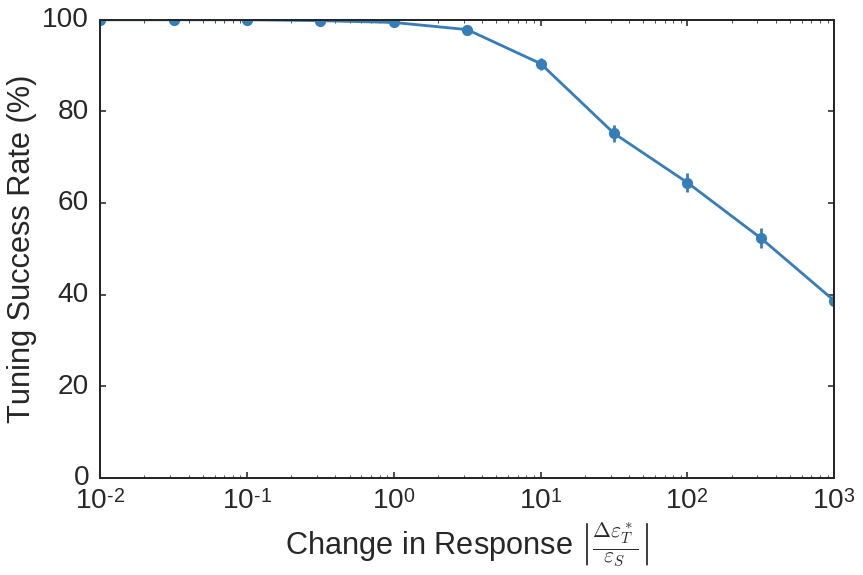

In [9]:

fig, ax1 = plt.subplots()

    
eta = np.array(df_agg['eta'])
        
fsat = np.array(df_agg['fsat'])
    
    
    
    
ax1.errorbar(eta, 100*fsat, 
            yerr=[100*df_agg['fsat_err_low'], 100*df_agg['fsat_err_up']], fmt="o-", color="#377eb8")
    
            
# ax1.legend(loc="upper right")
ax1.set_xlabel(r'Change in Response $\left|\frac{\Delta\varepsilon^*_T}{\varepsilon_S}\right|$')
ax1.set_ylabel(r'Tuning Success Rate (%)')
ax1.set_xscale('log')
ax1.set_xlim(1e-2, 1e3)
ax1.set_ylim(0,100)

plt.tight_layout()

plt.savefig("disc_success_rate.svg")
# plt.savefig("prob_success.png")

plt.show()

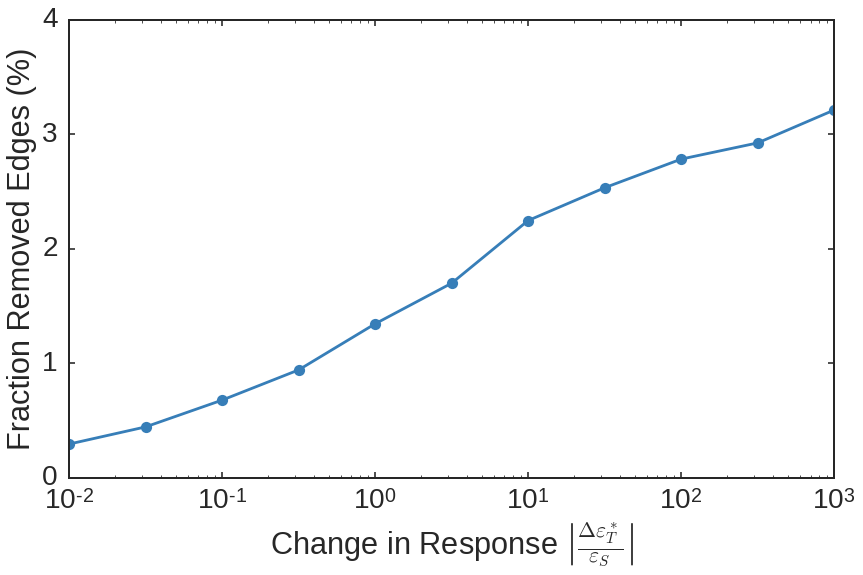

In [10]:

fig, ax1 = plt.subplots()

    
eta = np.array(df_agg[df_agg.NR > 0]['eta'])  
NR = np.array(df_agg[df_agg.NR > 0]['rhoR'])*100
NR_err = np.array(df_agg[df_agg.NR > 0]['rhoR_err'])*100
    
    
    
ax1.errorbar(eta, NR, yerr=NR_err, fmt="o-", color="#377eb8")
    
          
# ax1.legend(loc="upper right")
ax1.set_xlabel(r'Change in Response $\left|\frac{\Delta\varepsilon^*_T}{\varepsilon_S}\right|$')
ax1.set_ylabel(r'Fraction Removed Edges (%)')
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_xlim(1e-2, 1e3)
ax1.set_ylim(0,4)
ax1.set_yticks(np.linspace(0, 4, 5))

plt.tight_layout()

plt.savefig("disc_rem_bonds.svg")

plt.show()